In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from functools import lru_cache
from typing import Union, List, Tuple
import os
import sys
if os.path.abspath('../') not in sys.path:
    sys.path.append(os.path.abspath('../'))
from t_core.bsplinefield import BSplineField, _BSplineField1d

[ 2.94048195e-15  1.00000000e+00 -2.52587637e-17  1.00000000e+00
 -5.61533223e-16]


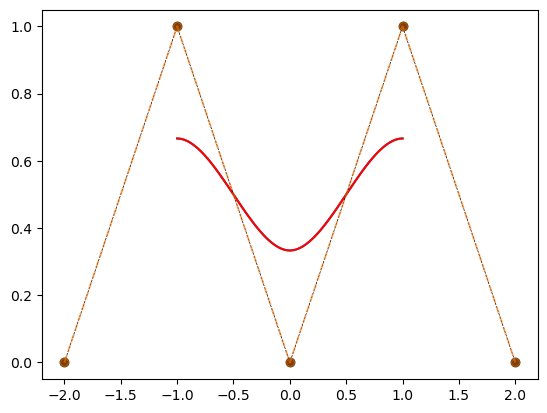

In [2]:
weights = np.array([0.,1.,0.,1.,0.])
bf = _BSplineField1d(weights, False)
x = np.linspace(-1+1e-4, 1-1e-4, 100)
t = x - bf.origin - bf.dx
# indices = np.floor(t/bf.dx).astype(int)   
# plt.plot(x, indices, c='k', ls='-')
u = bf.displacement(x)
u1 = bf.get_A_matrix(x) @ weights
grid_locations = bf.origin + np.arange(0, bf.phi_x.shape[0]) * bf.dx
plt.plot(x, u)
plt.plot(x, u1, c='r')
plt.plot(grid_locations, bf.phi_x, c='k', lw=0.5, ls='--', marker='o')
# infer weights
A = bf.get_A_matrix(x)
weights = np.linalg.lstsq(A, u, rcond=None)[0]
print(weights)
plt.plot(grid_locations, weights, c='C1', lw=1.5, alpha=0.5, ls='--', marker='o')
plt.show()

## 2d

In [3]:
from numpy import ndarray


class BSplineField2d(_BSplineField1d):
    def __init__(self, phi_x: np.ndarray, support_outside: bool = False) -> None:
        if not isinstance(phi_x, np.ndarray):
            phi_x = np.array(phi_x)
        assert phi_x.ndim == 3
        _,nx,ny = phi_x.shape
        assert nx > 3 and ny > 3
        self.phi_x = phi_x
        # provide support over -1 to 1
        self.grid_size = np.array([nx, ny])
        # provide support for range -1 to 1 along each dimension
        self.spacing = 2 / (self.grid_size - 3)
        self.origin = -1 - self.spacing
        self.support_outside = support_outside
    
    def displacement(self, x: np.ndarray, y: np.ndarray, i: int) -> ndarray:
        shape = x.shape
        if x.ndim>1:
            assert x.shape == y.shape
            # meshgrid so flatten
            x = x.flatten()
            y = y.flatten()

        A = self.get_A_matrix(x, y)
        u = A @ self.phi_x[i].flatten()

        if len(shape) > 1:
            return u.reshape(shape)
        else:
            return u

    def get_A_matrix(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        npoints = len(x)
        assert len(y) == npoints
        dx, dy = self.spacing
        nx, ny = self.grid_size
        x = x - self.origin[0] - dx
        y = y - self.origin[1] - dy
        indices_x = np.floor(x/dx).astype(int)
        indices_y = np.floor(y/dy).astype(int)
        u = x/dx - indices_x
        v = y/dy - indices_y
        ind_matrix_x = np.column_stack([indices_x + i for i in range(4)]) # [npoints, 4]
        ind_matrix_x = np.repeat(ind_matrix_x, 4, axis=1) # [npoints, 16]
        ind_matrix_y = np.column_stack([indices_y + i for i in range(4)]) # [npoints, 4]
        ind_matrix_y = np.tile(ind_matrix_y, (1, 4)) # [npoints, 16]
        # out of support where any index is negative or >= len(phi_x)
        out_of_support_x = np.any((ind_matrix_x < 0) | (ind_matrix_x >= nx), axis=1)
        out_of_support_y = np.any((ind_matrix_y < 0) | (ind_matrix_y >= ny), axis=1)
        out_of_support = out_of_support_x | out_of_support_y
        flat_index = np.ravel_multi_index((ind_matrix_x, ind_matrix_y), (nx, ny), mode='clip')
        weights_x = np.column_stack([self.bspline(u, i) for i in range(4)]) # [p, i]
        weights_y = np.column_stack([self.bspline(v, i) for i in range(4)]) # [p, j]
        weights = np.einsum('pi,pj->pij', weights_x, weights_y).reshape(npoints, 16)
        A = np.zeros((len(x), nx*ny))
        A[np.arange(len(x))[:,None], flat_index] = weights
        if not self.support_outside:
            A[out_of_support] = np.nan
        return A

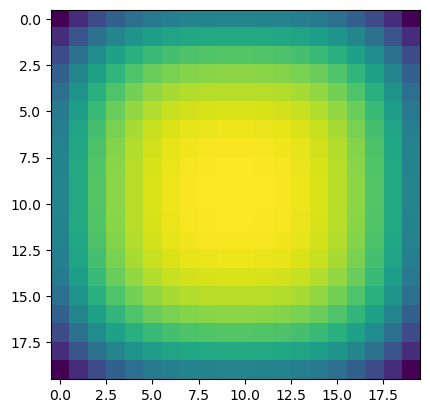

In [4]:
weights = np.array([[0,0,0,0,0],[0,1,1,1,0],[0,1,1,1,0],[0,1,1,1,0],[0,0,0,0,0]]).reshape(1,5,5)
bf = BSplineField2d(weights, False)
x = np.linspace(-1+1e-4, 1-1e-4, 20)
y = np.linspace(-1+1e-4, 1-1e-4, 20)
X,Y = np.meshgrid(x,y)
_x, _y = np.row_stack([X.flatten(), Y.flatten()])
A = bf.get_A_matrix(_x, _y)
u = A @ weights.flatten()
u = u.reshape(X.shape)
plt.imshow(u)
plt.show()
assert np.allclose(u, bf.displacement(X, Y, 0), equal_nan=True)
# u = bf.displacement(X, Y, 0)
# plt.imshow(u)
# plt.show()
w = np.linalg.lstsq(A, u.flatten(), rcond=None)[0]
assert np.allclose(w, weights.flatten())

## 3d

In [5]:
class BSplineField3d(_BSplineField1d):
    # inherit from 1d bspline field to get the bspline function
    def __init__(self, phi_x: np.ndarray, support_outside: bool = False) -> None:
        if not isinstance(phi_x, np.ndarray):
            phi_x = np.array(phi_x)
        assert phi_x.ndim == 4
        _,nx,ny,nz = phi_x.shape
        assert nx > 3 and ny > 3 and nz > 3
        self.phi_x = phi_x
        # provide support over -1 to 1
        self.grid_size = np.array([nx, ny, nz])
        # provide support for range -1 to 1 along each dimension
        self.spacing = 2 / (self.grid_size - 3)
        self.origin = -1 - self.spacing
        self.support_outside = support_outside
    
    def displacement(self, x: np.ndarray, y: np.ndarray, z: np.ndarray, i: int) -> np.ndarray:
        shape = x.shape
        if x.ndim>1:
            assert x.shape == y.shape
            # meshgrid so flatten
            x = x.flatten()
            y = y.flatten()
            z = z.flatten()

        A = self.get_A_matrix(x, y, z)
        u = A @ self.phi_x[i].flatten()

        if len(shape) > 1:
            return u.reshape(shape)
        else:
            return u

    def get_A_matrix(self, x: np.ndarray, y: np.ndarray, z: np.ndarray) -> np.ndarray:
        assert x.shape == y.shape == z.shape
        npoints = len(x)
        dx, dy, dz = self.spacing
        nx, ny, nz = self.grid_size
        x = x - self.origin[0] - dx
        y = y - self.origin[1] - dy
        z = z - self.origin[2] - dz
        indices_x = np.floor(x/dx).astype(int)
        indices_y = np.floor(y/dy).astype(int)
        indices_z = np.floor(z/dz).astype(int)
        u = x/dx - indices_x
        v = y/dy - indices_y
        w = z/dz - indices_z
        ind_matrix_x = np.column_stack([indices_x + i for i in range(4)]) # [npoints, 4]
        ind_matrix_x = np.repeat(ind_matrix_x, 16, axis=1) # [npoints, 64]
        ind_matrix_y = np.column_stack([indices_y + i for i in range(4)]) # [npoints, 4]
        ind_matrix_y = np.repeat(np.tile(ind_matrix_y, (1, 4)), 4, axis=1) # [npoints, 64]
        ind_matrix_z = np.column_stack([indices_z + i for i in range(4)]) # [npoints, 4]
        ind_matrix_z = np.tile(ind_matrix_z, (1, 16)) # [npoints, 64]
        # out of support where any index is negative or >= len(phi_x)
        out_of_support_x = np.any((ind_matrix_x < 0) | (ind_matrix_x >= nx), axis=1)
        out_of_support_y = np.any((ind_matrix_y < 0) | (ind_matrix_y >= ny), axis=1)
        out_of_support_z = np.any((ind_matrix_z < 0) | (ind_matrix_z >= nz), axis=1)
        out_of_support = out_of_support_x | out_of_support_y | out_of_support_z
        flat_index = np.ravel_multi_index((ind_matrix_x, ind_matrix_y, ind_matrix_z), (nx, ny, nz), mode='clip')
        weights_x = np.column_stack([self.bspline(u, i) for i in range(4)]) # [p, i]
        weights_y = np.column_stack([self.bspline(v, i) for i in range(4)]) # [p, j]
        weights_z = np.column_stack([self.bspline(w, i) for i in range(4)]) # [p, k]
        weights = np.einsum('pi,pj,pk->pijk', weights_x, weights_y, weights_z).reshape(npoints, 64)
        A = np.zeros((npoints, nx*ny*nz))
        A[np.arange(npoints)[:,None], flat_index] = weights
        if not self.support_outside:
            A[out_of_support] = np.nan
        return A

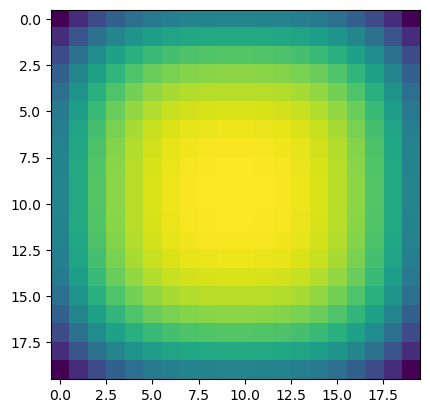

In [6]:
weights = np.array([[0,0,0,0,0],[0,1,1,1,0],[0,1,1,1,0],[0,1,1,1,0],[0,0,0,0,0]]).reshape(1,5,5)
weights = np.stack([np.zeros_like(weights), weights, weights, weights, np.zeros_like(weights)]).reshape(1,5,5,5)
bf = BSplineField3d(weights, False)
x = np.linspace(-1+1e-4, 1-1e-4, 20)
y = np.linspace(-1+1e-4, 1-1e-4, 20)
z = np.linspace(-1+1e-4, 1-1e-4, 20)
X,Y,Z = np.meshgrid(x,y,z, indexing='ij')
_x, _y, _z = np.row_stack([X.flatten(), Y.flatten(), Z.flatten()])
A = bf.get_A_matrix(_x, _y, _z)
u = A @ weights.flatten()
u = u.reshape(X.shape)
plt.imshow(u[:,:,2])
plt.show()
assert np.allclose(u, bf.displacement(X, Y, Z, 0), equal_nan=True)
# u = bf.displacement(X, Y, 0)
# plt.imshow(u)
# plt.show()
w = np.linalg.lstsq(A, u.flatten(), rcond=None)[0]
assert np.allclose(w, weights.flatten())

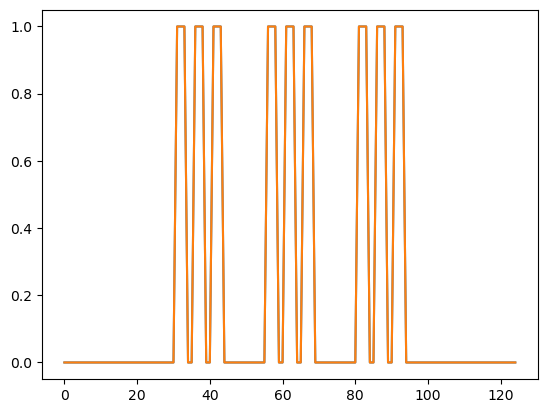

In [7]:
plt.plot(weights.flatten())
plt.plot(w)

## verify new torch version

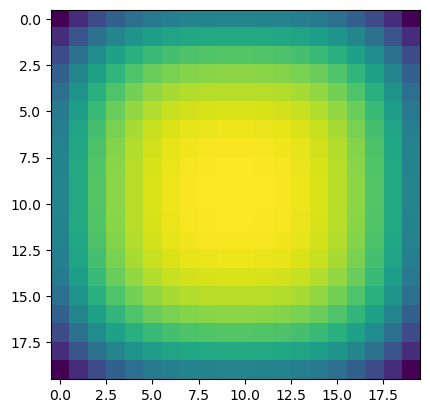

In [8]:
weights = np.array([[0,0,0,0,0],[0,1,1,1,0],[0,1,1,1,0],[0,1,1,1,0],[0,0,0,0,0]]).reshape(1,5,5)
weights = np.stack([np.zeros_like(weights), weights, weights, weights, np.zeros_like(weights)]).reshape(1,5,5,5)
tbf = BSplineField(weights, False)
x = np.linspace(-1+1e-4, 1-1e-4, 20)
y = np.linspace(-1+1e-4, 1-1e-4, 20)
z = np.linspace(-1+1e-4, 1-1e-4, 20)
X,Y,Z = [torch.tensor(xi) for xi in np.meshgrid(x,y,z, indexing='ij')]
_x, _y, _z = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=0)
A = tbf.get_A_matrix(_x, _y, _z)
u = A.numpy() @ weights.flatten()
u = u.reshape(X.shape)
plt.imshow(u[:,:,2])
plt.show()
assert np.allclose(u, tbf.displacement(X, Y, Z, 0).numpy(), equal_nan=True)
# u = bf.displacement(X, Y, 0)
# plt.imshow(u)
# plt.show()
w = torch.linalg.lstsq(A.double(), torch.tensor(u).flatten().double(), rcond=None).solution
assert np.allclose(w, weights.flatten())
assert np.allclose(tbf.compute_weights_from_displacement(_x, _y, _z, torch.tensor(u).flatten().double()).numpy(), weights.flatten())
assert np.allclose(u, bf.displacement(X.numpy(), Y.numpy(), Z.numpy(), 0), equal_nan=True)

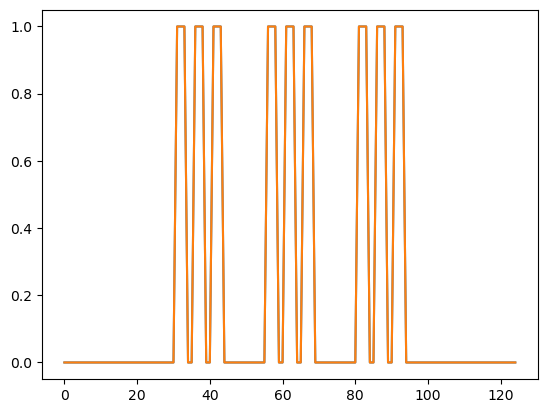

In [9]:
plt.plot(tbf.compute_weights_from_displacement(_x, _y, _z, torch.tensor(u.flatten())).numpy())
plt.plot(weights.flatten())